# Zadanie 1:

Proszę znaleźć i porównać przynajmniej 2 metody obliczania reprezentacji wektorowej tekstu na podstawie osadzeń słów. Proszę je przetestować na klasyfikacji wieloklasowej tekstu. 
Wybrałam zbiór zawierający treści mailów: https://www.kaggle.com/dipankarsrirag/topic-modelling-on-emails

Wybrane metody:

* BOW ważone TF-IDF
* Skip-gram ważone TF-IDF
* DBOW

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import regex
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 
from gensim.models import Word2Vec
import nltk
from nltk import tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from nltk.corpus import stopwords 
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## Wczytanie i oczyszczenie danych

Dane są umieszczone w postaci listy tupli treści mailów i ich odpowiadających labelek.

* 0 - Crime
* 1 - Entertainment
* 2 - Politics
* 3 - Science

In [2]:
data_folder = "./MailClassificationData"
mails_files = glob.glob(data_folder + "/*/*.txt")

In [3]:
wordnet_lemmatizer = WordNetLemmatizer()

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

for punct in punctuation:
    stop_words.append(punct)

def filter_text(text, stop_words):
    word_tokens = WordPunctTokenizer().tokenize(text.lower())
    filtered_text = [regex.sub(u'\p{^Latin}', u'', w) for w in word_tokens if w.isalpha() and len(w) > 1]
    filtered_text = [wordnet_lemmatizer.lemmatize(w, pos="v") for w in filtered_text if not w in stop_words] 
    return " ".join(filtered_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliazur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juliazur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
mails_with_labels = []
for mail_file in mails_files:
    mail_content = ""
    
    with open(mail_file, encoding='utf-8') as file:
        try:
            lines = file.readlines()
        except:
            print('Cannot read ', mail_file)
        content = ' '.join(lines)
        cleaned_mail_content = filter_text(content, stop_words)
    label = -1
    if 'Crime' in mail_file:
        label = 0
    elif 'Entertainment' in mail_file:
        label = 1
    elif 'Politics' in mail_file:
        label = 2
    elif 'Science' in mail_file:
        label = 3
    if label != -1:
        mails_with_labels.append((cleaned_mail_content, label))

## Podział na zbiór treningowy i testowy, analiza liczności klas

In [5]:
X = [text for text, label in mails_with_labels]
y = [label for text, label in mails_with_labels]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [7]:
number_of_examples_crime = len([y_train[i] for i, text in enumerate(X_train) if y_train[i] == 0])
number_of_examples_entertainment = len([y_train[i] for i, text in enumerate(X_train) if y_train[i] == 1])
number_of_examples_politics = len([y_train[i] for i, text in enumerate(X_train) if y_train[i] == 2])
number_of_examples_science = len([y_train[i] for i, text in enumerate(X_train) if y_train[i] == 3])

<BarContainer object of 4 artists>

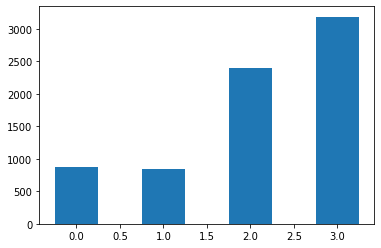

In [8]:
plt.bar(np.arange(4), 
        [number_of_examples_crime, number_of_examples_entertainment, 
         number_of_examples_politics, number_of_examples_science],
       width=0.5,
       align='center')

Można zauważyć, że klasy są nierównoliczne.

# Word2vec - CBOW weighted with TF-IDF

In [191]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_vectorizer.fit_transform(X_train)
tfidf_vectorizer.transform(X_test)

<1828x44250 sparse matrix of type '<class 'numpy.float64'>'
	with 203579 stored elements in Compressed Sparse Row format>

In [192]:
list(tfidf_vectorizer.vocabulary_.items())[:10]

[('see', 34896),
 ('guess', 16365),
 ('would', 43392),
 ('like', 22758),
 ('represent', 32910),
 ('worst', 43382),
 ('american', 1403),
 ('israeli', 20095),
 ('politics', 30275),
 ('matter', 24055)]

In [193]:
def weighted_sum_vectors(words, vectors, tfidf_vocabulary):
    weights = []
    for word in words:
        if word in tfidf_vocabulary.keys():
            weight = tfidf_vocabulary[word]
        else:
            weight = 0.
        weights.append(weight)
    vec_sum = np.zeros(vectors[0].shape[0])
    for i in range(len(weights)):
        vec_sum = vec_sum + (vectors[i] * weights[i])
    return vec_sum/sum(weights)

In [194]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train)]
documents_words = [doc.words.split(' ') for doc in documents]

model = Word2Vec(size=100, window=2, min_count=1, workers=4)
model.build_vocab(documents_words)

In [195]:
model.train(documents_words, total_examples=model.corpus_count, epochs=model.epochs)

(6238497, 6419650)

Po treningu na danych treningowych, należy dotrenować model z zablokowanymi już istniejącymi wektorami. Taki podjeście musi zostać zastosowane, ponieważ ten model nie potrafi dokonywać predykcji wektora dla nieznanego słowa.

In [196]:
model.trainables.vectors_lockf = np.zeros(model.trainables.vectors_lockf.shape)

In [197]:
test_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_test)]
test_documents_words = [doc.words.split(' ') for doc in test_documents]

In [198]:
model.build_vocab(test_documents_words, update=True)

In [199]:
model.train(test_documents_words, total_examples=model.corpus_count, epochs=model.epochs)

(1512972, 1555215)

In [200]:
word2vec_X_train = {}
for doc_id in range(len(documents)):
    words = []
    for word in documents[doc_id].words.split(' '):
        words.append(word)
        inferred_vector = model.wv[word]
        if doc_id not in word2vec_X_train.keys():
            word2vec_X_train[doc_id] = []
        word2vec_X_train[doc_id].append(inferred_vector)
    single_vector = weighted_sum_vectors(words, word2vec_X_train[doc_id], tfidf_vectorizer.vocabulary_)
    word2vec_X_train[doc_id] = single_vector

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [201]:
word2vec_X_test = {}
for text_id in range(len(X_test)):
    words = []
    for word in X_test[text_id].split(' '):
        words.append(word)
        inferred_vector = model.wv[word]
        if text_id not in word2vec_X_test.keys():
            word2vec_X_test[text_id] = [] 
        word2vec_X_test[text_id].append(inferred_vector)
    single_vector = weighted_sum_vectors(words, word2vec_X_test[text_id], tfidf_vectorizer.vocabulary_)
    word2vec_X_test[text_id] = single_vector

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [202]:
word2vec_X_train = list(word2vec_X_train.values())

In [203]:
word2vec_X_test = list(word2vec_X_test.values())

In [204]:
word2vec_X_train = np.array(word2vec_X_train)
word2vec_X_test = np.array(word2vec_X_test)

In [205]:
print(word2vec_X_train.shape)
print(word2vec_X_test.shape)

(7311, 100)
(1828, 100)


# Word2vec - Skip-gram weighted with TF-IDF

In [206]:
sg_model = Word2Vec(size=100, window=2, min_count=1, workers=4, sg=1)
sg_model.build_vocab(documents_words)
sg_model.train(documents_words, total_examples=sg_model.corpus_count, epochs=sg_model.epochs)

(6237744, 6419650)

Tak jak poprzednio trzeba dotrenować model z zablokowanymi wektorami.

In [207]:
sg_model.trainables.vectors_lockf = np.zeros(sg_model.trainables.vectors_lockf.shape)

In [208]:
sg_model.build_vocab(test_documents_words, update=True)

In [209]:
sg_model.train(test_documents_words, total_examples=sg_model.corpus_count, epochs=sg_model.epochs)

(1512911, 1555215)

In [210]:
sg_X_train = {}
for doc_id in range(len(documents)):
    words = []
    for word in documents[doc_id].words.split(' '):
        words.append(word)
        inferred_vector = sg_model.wv[word]
        if doc_id not in sg_X_train.keys():
            sg_X_train[doc_id] = []
        sg_X_train[doc_id].append(inferred_vector)
    single_vector = weighted_sum_vectors(words, sg_X_train[doc_id], tfidf_vectorizer.vocabulary_)
    sg_X_train[doc_id] = single_vector

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [211]:
sg_X_test = {}
for text_id in range(len(X_test)):
    words = []
    for word in X_test[text_id].split(' '):
        words.append(word)
        inferred_vector = sg_model.wv[word]
        if text_id not in sg_X_test.keys():
            sg_X_test[text_id] = [] 
        sg_X_test[text_id].append(inferred_vector)
    single_vector = weighted_sum_vectors(words, sg_X_test[text_id], tfidf_vectorizer.vocabulary_)
    sg_X_test[text_id] = single_vector

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [212]:
sg_X_train = list(sg_X_train.values())

In [213]:
sg_X_test = list(sg_X_test.values())

In [214]:
sg_X_train = np.array(sg_X_train)
sg_X_test = np.array(sg_X_test)

In [215]:
print(sg_X_train.shape)
print(sg_X_test.shape)

(7311, 100)
(1828, 100)


# Doc2vec - DBOW

In [216]:
doc2vec_model = Doc2Vec(vector_size=100, window=2, min_count=1, workers=4)
doc2vec_model.build_vocab(documents)

In [217]:
doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

In [218]:
doc2vec_X_train = []
for doc_id in range(len(documents)):
    inferred_vector = doc2vec_model.infer_vector([documents[doc_id].words])
    doc2vec_X_train.append(inferred_vector)

In [219]:
doc2vec_X_test = []
for text in X_test:
    inferred_vector = doc2vec_model.infer_vector([text])
    doc2vec_X_test.append(inferred_vector)

In [220]:
doc2vec_X_train = np.array(doc2vec_X_train)
doc2vec_X_test = np.array(doc2vec_X_test)

In [221]:
print(doc2vec_X_train.shape)
print(doc2vec_X_test.shape)

(7311, 100)
(1828, 100)


# Klasyfikacja

In [222]:
def print_results(classifier, predictions):
    print(classifier)
    for name, acc, prec, rec, f1 in predictions:
        print(' ', name)
        print('     Accuracy: ', acc)
        print('     Precision: ', prec)
        print('     Recall: ', rec)
        print('     F1: ', f1, '\n')

In [223]:
def multiclass_confusion_matrix(name, y, predictions):
    plt.figure(figsize=(15,10))
    ax = sns.heatmap(confusion_matrix(y, predictions),annot=True)
    ax = ax.set(xlabel='Predicted',ylabel='True',title='Confusion Matrix',
              xticklabels=(['Crime', 'Entertainment', 'Politics','Science']),
              yticklabels=(['Crime', 'Entertainment', 'Politics','Science']))
    plt.title(name)

## Logistic Regression


In [257]:
lr_bow = LogisticRegression().fit(word2vec_X_train, y_train)
lr_bow_predictions = lr_bow.predict(word2vec_X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [260]:
lr_sg = LogisticRegression().fit(sg_X_train, y_train)
lr_sg_predictions = lr_sg.predict(sg_X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [261]:
lr_dbow = LogisticRegression().fit(doc2vec_X_train, y_train)
lr_dbow_predictions = lr_dbow.predict(doc2vec_X_test)

In [262]:
lr_bow_acc = accuracy_score(y_test, lr_bow_predictions)
lr_bow_rec = recall_score(y_test, lr_bow_predictions, average='weighted')
lr_bow_prec = precision_score(y_test, lr_bow_predictions, average='weighted')
lr_bow_f1 = f1_score(y_test, lr_bow_predictions, average='weighted')

In [263]:
lr_sg_acc = accuracy_score(y_test, lr_sg_predictions)
lr_sg_rec = recall_score(y_test, lr_sg_predictions, average='weighted')
lr_sg_prec = precision_score(y_test, lr_sg_predictions, average='weighted')
lr_sg_f1 = f1_score(y_test, lr_sg_predictions, average='weighted')

In [264]:
lr_dbow_acc = accuracy_score(y_test, lr_dbow_predictions)
lr_dbow_rec = recall_score(y_test, lr_dbow_predictions, average='weighted')
lr_dbow_prec = precision_score(y_test, lr_dbow_predictions, average='weighted')
lr_dbow_f1 = f1_score(y_test, lr_dbow_predictions, average='weighted')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [265]:
lr = [('BOW', lr_bow_acc, lr_bow_prec, lr_bow_rec, lr_bow_f1), 
      ('Skip-gram', lr_sg_acc, lr_sg_prec, lr_sg_rec, lr_sg_f1), 
      ('DBOW', lr_dbow_acc, lr_dbow_prec, lr_dbow_rec, lr_dbow_f1)]

In [266]:
print_results('Logistic regression', lr)

Logistic regression
  BOW
     Accuracy:  0.6695842450765864
     Precision:  0.6169839110081291
     Recall:  0.6695842450765864
     F1:  0.6360932106009419 

  Skip-gram
     Accuracy:  0.6832603938730853
     Precision:  0.6326299657861938
     Recall:  0.6832603938730853
     F1:  0.6522335082407338 

  DBOW
     Accuracy:  0.4365426695842451
     Precision:  0.19056950236773937
     Recall:  0.4365426695842451
     F1:  0.26531687001388243 



Najlepsze wyniki uzyskał Skip-gram pod kątem wszystkich metryk, ale wyniki te są dość słabe.

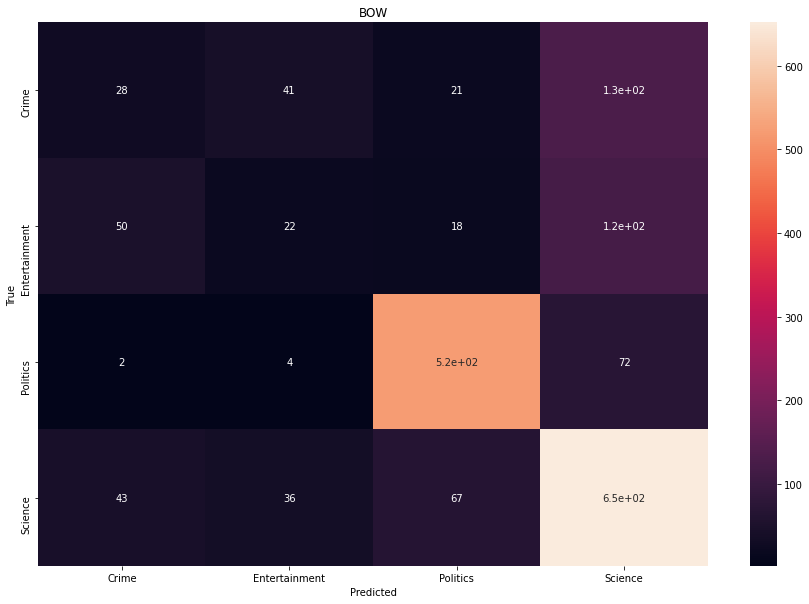

In [267]:
multiclass_confusion_matrix('BOW', y_test, lr_bow_predictions)

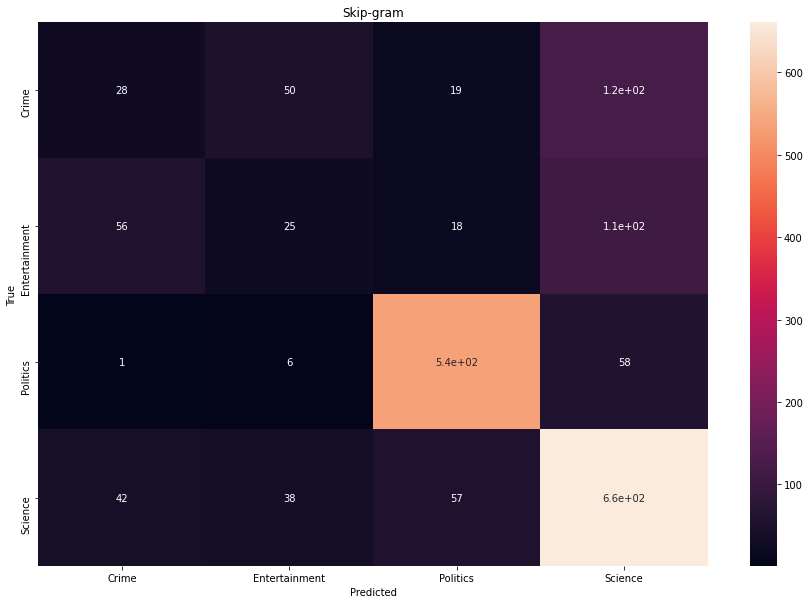

In [268]:
multiclass_confusion_matrix('Skip-gram', y_test, lr_sg_predictions)

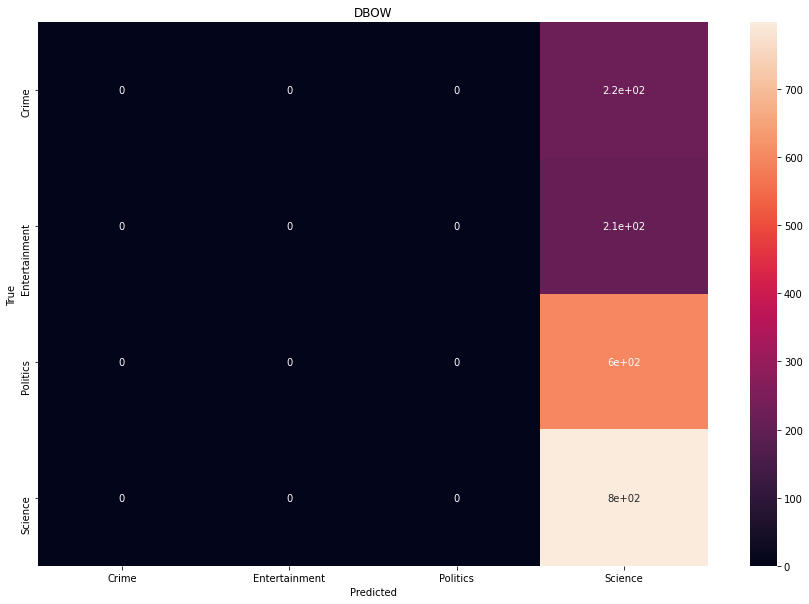

In [269]:
multiclass_confusion_matrix('DBOW', y_test, lr_dbow_predictions)

Macierze błędów wykazały problem nierówności klas. Zdecydowana większość przykładów należała do jednej z dwóch klas - *Politics* lub *Science*. Metoda DBOW wykazała ten dysbalans klasyfikację tylko do klasy *Science*. Metody BOW i Skip-gram dobrze poradziły sobie z klasami *Politics* i *Science*, a z dwoma pozostałymi gorzej. 

## Naive Bayes

Ponieważ wektory zawierają ujemne wartości zostały przeskalowane do wartości z zakresu (0,1).

In [270]:
scaler = MinMaxScaler()

scaled_bow_X_train = scaler.fit_transform(word2vec_X_train)
scaled_bow_X_test = scaler.transform(word2vec_X_test)

scaled_sg_X_train = scaler.fit_transform(sg_X_train)
scaled_sg_X_test = scaler.transform(sg_X_test)

scaled_dbow_X_train = scaler.fit_transform(doc2vec_X_train)
scaled_dbow_X_test = scaler.transform(doc2vec_X_test)

In [271]:
nb_bow = MultinomialNB().fit(scaled_bow_X_train, y_train)
nb_bow_predictions = nb_bow.predict(scaled_bow_X_test)

In [272]:
nb_sg = MultinomialNB().fit(scaled_sg_X_train, y_train)
nb_sg_predictions = nb_sg.predict(scaled_sg_X_test)

In [273]:
nb_dbow = MultinomialNB().fit(scaled_dbow_X_train, y_train)
nb_dbow_predictions = nb_dbow.predict(scaled_dbow_X_test)

In [274]:
nb_bow_acc = accuracy_score(y_test, nb_bow_predictions)
nb_bow_rec = recall_score(y_test, nb_bow_predictions, average='weighted')
nb_bow_prec = precision_score(y_test, nb_bow_predictions, average='weighted')
nb_bow_f1 = f1_score(y_test, nb_bow_predictions, average='weighted')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [275]:
nb_sg_acc = accuracy_score(y_test, nb_sg_predictions)
nb_sg_rec = recall_score(y_test, nb_sg_predictions, average='weighted')
nb_sg_prec = precision_score(y_test, nb_sg_predictions, average='weighted')
nb_sg_f1 = f1_score(y_test, nb_sg_predictions, average='weighted')

In [277]:
nb_dbow_acc = accuracy_score(y_test, nb_dbow_predictions)
nb_dbow_rec = recall_score(y_test, nb_dbow_predictions, average='weighted')
nb_dbow_prec = precision_score(y_test, nb_dbow_predictions, average='weighted')
nb_dbow_f1 = f1_score(y_test, nb_dbow_predictions, average='weighted')

In [278]:
nb = [('BOW', nb_bow_acc, nb_bow_prec, nb_bow_rec, nb_bow_f1), 
      ('Skip-gram', nb_sg_acc, nb_sg_prec, nb_sg_rec, nb_sg_f1), 
      ('DBOW', nb_dbow_acc, nb_dbow_prec, nb_dbow_rec, nb_dbow_f1)]

In [279]:
print_results('Multinomial Naive Bayes', nb)

Multinomial Naive Bayes
  BOW
     Accuracy:  0.562363238512035
     Precision:  0.5267115258762105
     Recall:  0.562363238512035
     F1:  0.47341985167551265 

  Skip-gram
     Accuracy:  0.5486870897155361
     Precision:  0.5327872921584594
     Recall:  0.5486870897155361
     F1:  0.45506902233117985 

  DBOW
     Accuracy:  0.4365426695842451
     Precision:  0.19056950236773937
     Recall:  0.4365426695842451
     F1:  0.26531687001388243 



W przypadku prostego klasyfikatora Bayesowskiego najlepszy wynik uzyskał BOW pod kątem *accuracy*, *recall* i *F1*. Najgorszy okazał się ponownie DBOW. Najwyższe *precision* uzyskała metoda Skip-gram.

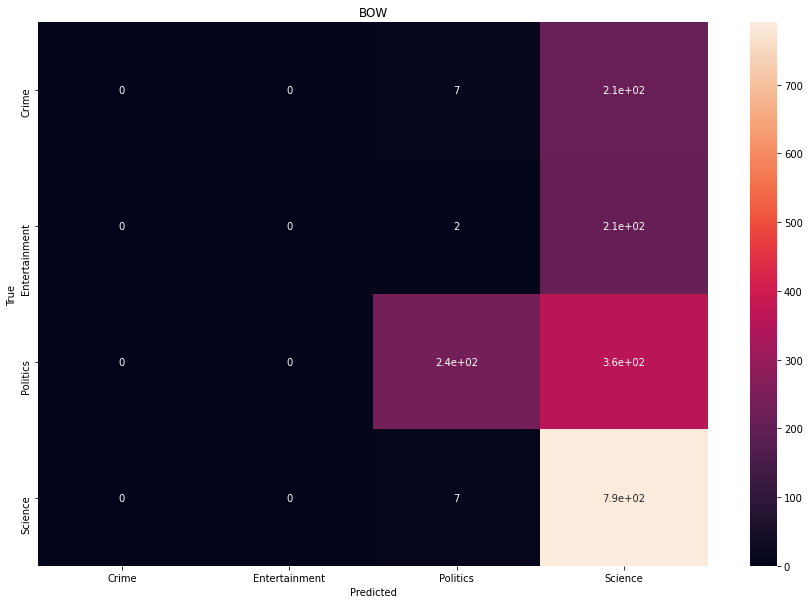

In [280]:
multiclass_confusion_matrix('BOW', y_test, nb_bow_predictions)

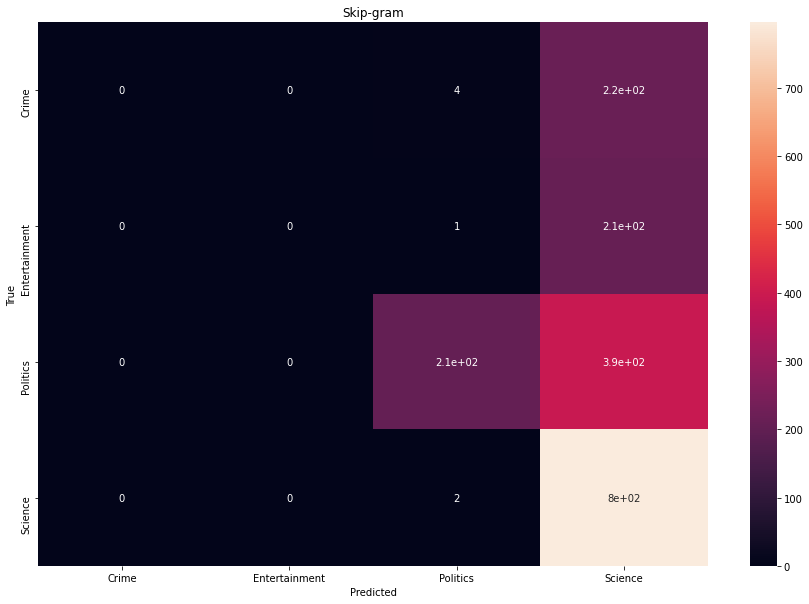

In [281]:
multiclass_confusion_matrix('Skip-gram', y_test, nb_sg_predictions)

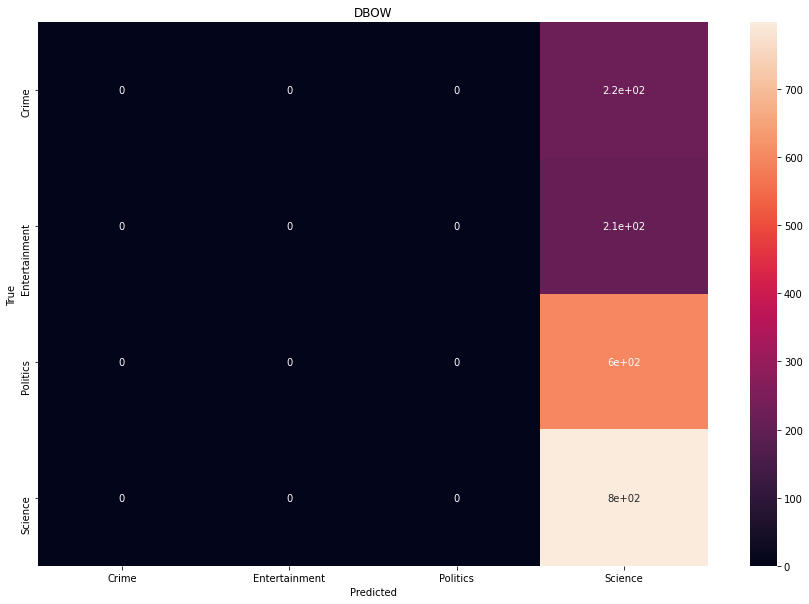

In [282]:
multiclass_confusion_matrix('DBOW', y_test, nb_dbow_predictions)

Macierze błędów ponownie wykazały, że najłatwiej zaklasyfikować tematy dotyczące polityki i nauki. Natomiast przestępczość i rozrywka mają niskie dokłądności. Przykładów z klasy *Politics* dokładności było ok. 2,5 raza więcej w stosunku do *Crime* i *Entertainment*, a *Science* 3 razy w zbiorze treningowym. BOW i Skip-gram potrafiły zaklasyfikować klasy 2 i 3, a DBOW ani razu nie próbował klasyfikować do kategorii innych niż *Science*.

## Decision Tree

In [285]:
dt_bow = DecisionTreeClassifier().fit(word2vec_X_train, y_train)
dt_bow_predictions = dt_bow.predict(word2vec_X_test)

In [286]:
dt_sg = DecisionTreeClassifier().fit(sg_X_train, y_train)
dt_sg_predictions = dt_sg.predict(sg_X_test)

In [287]:
dt_dbow = DecisionTreeClassifier().fit(doc2vec_X_train, y_train)
dt_dbow_predictions = dt_dbow.predict(doc2vec_X_test)

In [288]:
dt_bow_acc = accuracy_score(y_test, dt_bow_predictions)
dt_bow_rec = recall_score(y_test, dt_bow_predictions, average='weighted')
dt_bow_prec = precision_score(y_test, dt_bow_predictions, average='weighted')
dt_bow_f1 = f1_score(y_test, dt_bow_predictions, average='weighted')

In [289]:
dt_sg_acc = accuracy_score(y_test, dt_sg_predictions)
dt_sg_rec = recall_score(y_test, dt_sg_predictions, average='weighted')
dt_sg_prec = precision_score(y_test, dt_sg_predictions, average='weighted')
dt_sg_f1 = f1_score(y_test, dt_sg_predictions, average='weighted')

In [290]:
dt_dbow_acc = accuracy_score(y_test, dt_dbow_predictions)
dt_dbow_rec = recall_score(y_test, dt_dbow_predictions, average='weighted')
dt_dbow_prec = precision_score(y_test, dt_dbow_predictions, average='weighted')
dt_dbow_f1 = f1_score(y_test, dt_dbow_predictions, average='weighted')

In [291]:
dt = [('BOW', dt_bow_acc, dt_bow_prec, dt_bow_rec, dt_bow_f1), 
      ('Skip-gram', dt_sg_acc, dt_sg_rec, dt_sg_rec, dt_sg_f1), 
      ('DBOW', dt_dbow_acc, dt_dbow_prec, dt_dbow_rec, dt_dbow_f1)]

In [292]:
print_results('Decision Tree', dt)

Decision Tree
  BOW
     Accuracy:  0.5016411378555798
     Precision:  0.5869675656195058
     Recall:  0.5016411378555798
     F1:  0.5393625836545934 

  Skip-gram
     Accuracy:  0.5016411378555798
     Precision:  0.5016411378555798
     Recall:  0.5016411378555798
     F1:  0.5366933934025792 

  DBOW
     Accuracy:  0.26805251641137856
     Precision:  0.33517368638498285
     Recall:  0.26805251641137856
     F1:  0.29714145117232293 



W stosunku do MultinomialBayes ta metoda osiągnęła znacznie gorsze wyniki. W tym zestawieniu najlepiej wypadł BOW ze względu na *accuracy*, a TF-IDF pod kątem każdej innej miary. 

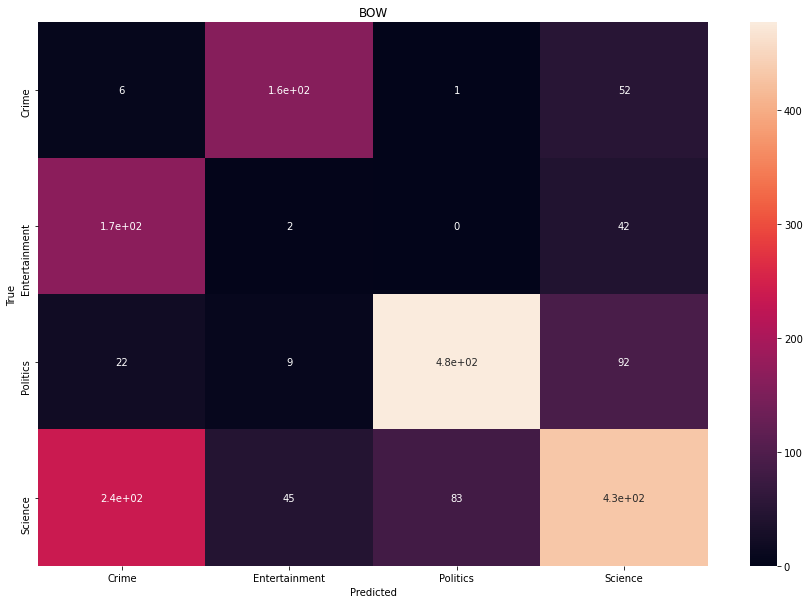

In [293]:
multiclass_confusion_matrix('BOW', y_test, dt_bow_predictions)

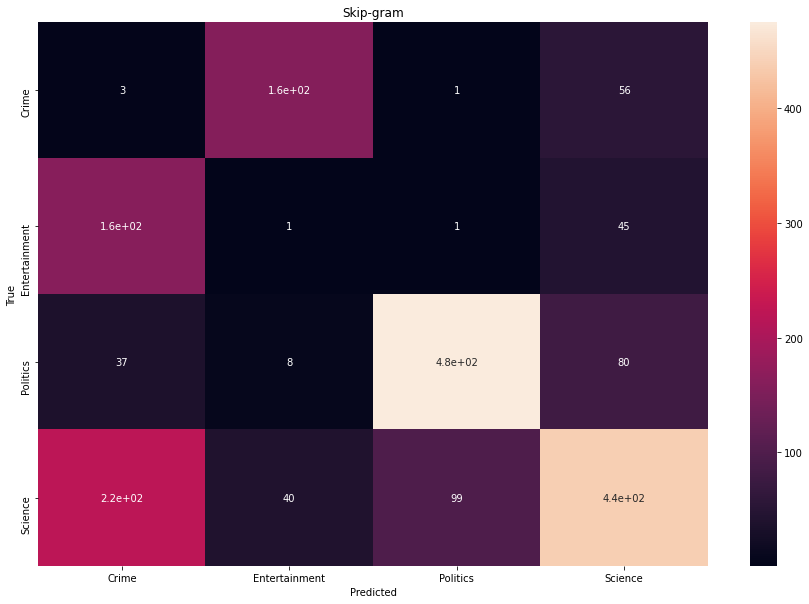

In [294]:
multiclass_confusion_matrix('Skip-gram', y_test, dt_sg_predictions)

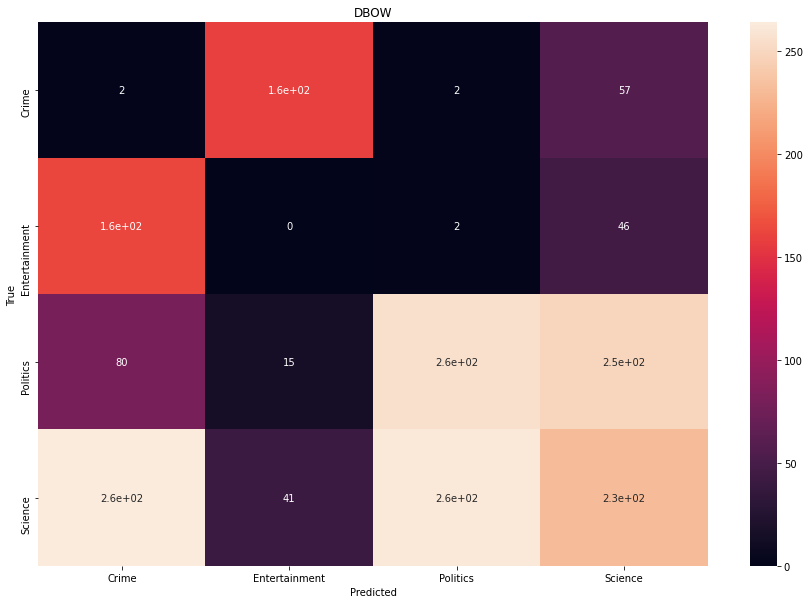

In [295]:
multiclass_confusion_matrix('DBOW', y_test, dt_dbow_predictions)

W przypadku tego klasyfikatora wszystkie wektory osiągnęły niskie wartości dokładności, ale w klasach, w których poprzednio było mało odpowiedzi teraz jest ich znacznie więcej szczególnie w przypadku DBOW. Poprzedni klasyfikator bardziej uległ dwóm dominującym w zbiorze klasom.

# Podsumowanie

## Zbalansowanie zbioru testowego

In [296]:
test_crime = len([y_test[i] for i, text in enumerate(X_test) if y_test[i] == 0])
test_entertainment = len([y_test[i] for i, text in enumerate(X_test) if y_test[i] == 1])
test_politics = len([y_test[i] for i, text in enumerate(X_test) if y_test[i] == 2])
test_science = len([y_test[i] for i, text in enumerate(X_test) if y_test[i] == 3])

<BarContainer object of 4 artists>

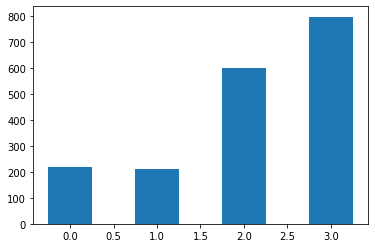

In [297]:
plt.bar(np.arange(4), 
        [test_crime, test_entertainment, 
         test_politics, test_science],
       width=0.5,
       align='center')

Rzeczywiście zbiór testowy był niezbalansowany.

## Porównanie metod na wykresie

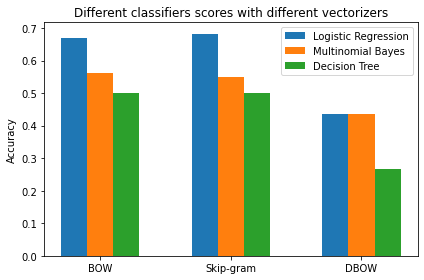

In [299]:
lr_acc = [lr[0][1], lr[1][1], lr[2][1]]
nb_acc = [nb[0][1], nb[1][1], nb[2][1]]
dt_acc = [dt[0][1], dt[1][1], dt[2][1]]

width = 0.2
labels = ['BOW', 'Skip-gram', 'DBOW']
x_vals = np.arange(len(labels))
fig, ax = plt.subplots()
rects1 = ax.bar(x_vals - width, lr_acc, width, label='Logistic Regression')
rects2 = ax.bar(x_vals, nb_acc, width, label='Multinomial Bayes')
rects3 = ax.bar(x_vals + width, dt_acc, width, label='Decision Tree')

ax.set_ylabel('Accuracy')
ax.set_title('Different classifiers scores with different vectorizers')
ax.set_xticks(x_vals)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

Ze względu na niezbalansowany zbiór danych wszystkie klasyfikatory uzyskały niezadowalające wyniki, co widać szczególnie na macierzach błędów. Klasyfikacja do klas, których było najwięcej w zbiorze ma wyosoką dokładność, co niestety dałoby podobny rezultat, gdyby zwyczajnie zgadywać jedną z tych dwóch klas.

Najlepszy wyniki wystąpił przy zestawie Logistic Regression oraz Skip-gram - ok. 68%. BOW uzyskiwał najlepsze wyniki w każdym innym klasyfikatorze. Mimo że ta metoda uzyskiwała wysokie wyniki, miała bardzo niską dokładność na klasach 0 i 1. Skip-gram zachowywał się podobnie do BOW jako, że obie opierają się o word2vec.

Najgorszy wynik uzyskał DBOW (doc2vec). Był najmniej odporny na brak zbalansowania zbioru. Oprócz przypadku *Decision Tree* zachowywał się podobnie - zgadywał klasę 3 lub 4. Mimo, że w *Decision Tree* uzyskał najmniejszą dokładność tylko w tym przypadku znalazły się prawidłowo zaklasyfikowane próbki z innych klas. Ta metoda wymagała najmniej przygotowań, przyjmowała cały tekst listy dokumentów.

Powodem takiego wyniku może być też fakt, że przynależność do danej klasy mogło definiować występowanie konkretnych słów np. w klasie *Politics* to było słowo *politics*. Metody word2vec kodowały każde słowo wektorem wielkości 100, które później były sumowane zgodnie z wagami tf-idf przetwarzane na wektor dokumentu także wielkości 100. Doc2vec kodował wektory metodą DBOW również za pomocą wektora długości 100. W tym wypadku lepszą metodą okazał się word2vec (obie metody BOW i Skip-gram miały podobne wyniki).